In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append("../../")

from dmp.data.logging import _get_sql_engine
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from joblib import Memory
from ipywidgets import interact, interact_manual

import scipy.interpolate

import plotly.graph_objects as go

import matplotlib.pyplot as plt

In [3]:
db = _get_sql_engine()

memory = Memory(location="./cache", verbose=0)

def query(query_string):
    with db.connect() as engine:
        return pd.read_sql(query_string, engine)

cached_query = memory.cache(query)

def clear_cache():
    memory.clear()
    
options = {
    "dataset": ['529_pollen',
        'sleep',
        'adult',
        '537_houses',
        'nursery',
        '201_pol',
        'mnist',
        'connect_4',
        'wine_quality_white'],
    "agg": ["avg", "min", "max"],
    "topology" : ["exponential", "rectangle", "trapezoid", "wide_first"],
    "loss": ['history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarity',
       'history_val_mean_squared_error', 'history_root_mean_squared_error',
       'history_val_mean_absolute_error',
       'history_kullback_leibler_divergence',
       'history_val_root_mean_squared_error',
       'history_mean_squared_logarithmic_error',
       'history_val_kullback_leibler_divergence',
       'history_val_mean_squared_logarithmic_error'],
    "residual_mode": ["none", "full"]
}

In [ ]:
query_string = f'''
select "config.budget", avg(a.val) as value, count(a.val), a.epoch, "config.dataset", "config.topology"
from
    materialized_experiments_0 t,
    unnest(t.history_loss) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname"='fixed_01' and
    "config.residual_mode"='none'
GROUP BY epoch, "config.budget", "config.dataset", "config.topology"
'''
df = cached_query(query_string)
df["effort"] = np.log((df["epoch"]))
#df["effort"] = np.log2((df["config.budget"]*(df["epoch"]))) - np.log2(df["config.budget"])
#df["effort"] = np.log(df["config.budget"]*df["epoch"])
#df["effort"] = np.log1p(df["config.budget"]*(df["epoch"]-1))


df["value"] = np.log(df["value"])

x_axes = np.linspace(df["effort"].min(), df["effort"].max(), 500)

ROWS = 7
COLS = 4

fig, axs = plt.subplots(ROWS,COLS, figsize=(11,8), dpi=100, sharex=True)

i = 0
for idx, gdf in df.groupby(["config.dataset", "config.topology"]):
    img = np.ndarray(shape=(22,500))

    for row_idx, row_df in gdf.groupby("config.budget"):
        intp = scipy.interpolate.interp1d(row_df["effort"],
                                          row_df["value"],
                                          kind='linear',
                                          bounds_error=False)

        row_idx = int(np.log2(row_idx)-5)
        img[row_idx, :] = intp(x_axes)

        
    value_min = df[df["config.dataset"]==idx[0]]["value"].min()
    value_max = df[df["config.dataset"]==idx[0]]["value"].max()
    
    ax = axs[i//COLS, i%COLS]
    ax.imshow(img, aspect="auto", vmin=value_min, vmax=value_max)

    if i%COLS == 0:
        ax.set_ylabel(idx[0])
    else:
        ax.yaxis.set_visible(False)

    if i//COLS != 6:
        ax.xaxis.set_visible(False)

    if i//COLS == 0:
        ax.set_title(idx[1])
        
    if i//COLS == 6:
        ax.set_xticks(list(range(0,500,200)), minor=False)
        labels = [f"{int(np.exp(x))}" for x in x_axes[::200]]
        ax.set_xticklabels(labels, fontdict=None, minor=False)

    i = i + 1
    
plt.tight_layout()




<IPython.core.display.Javascript object>


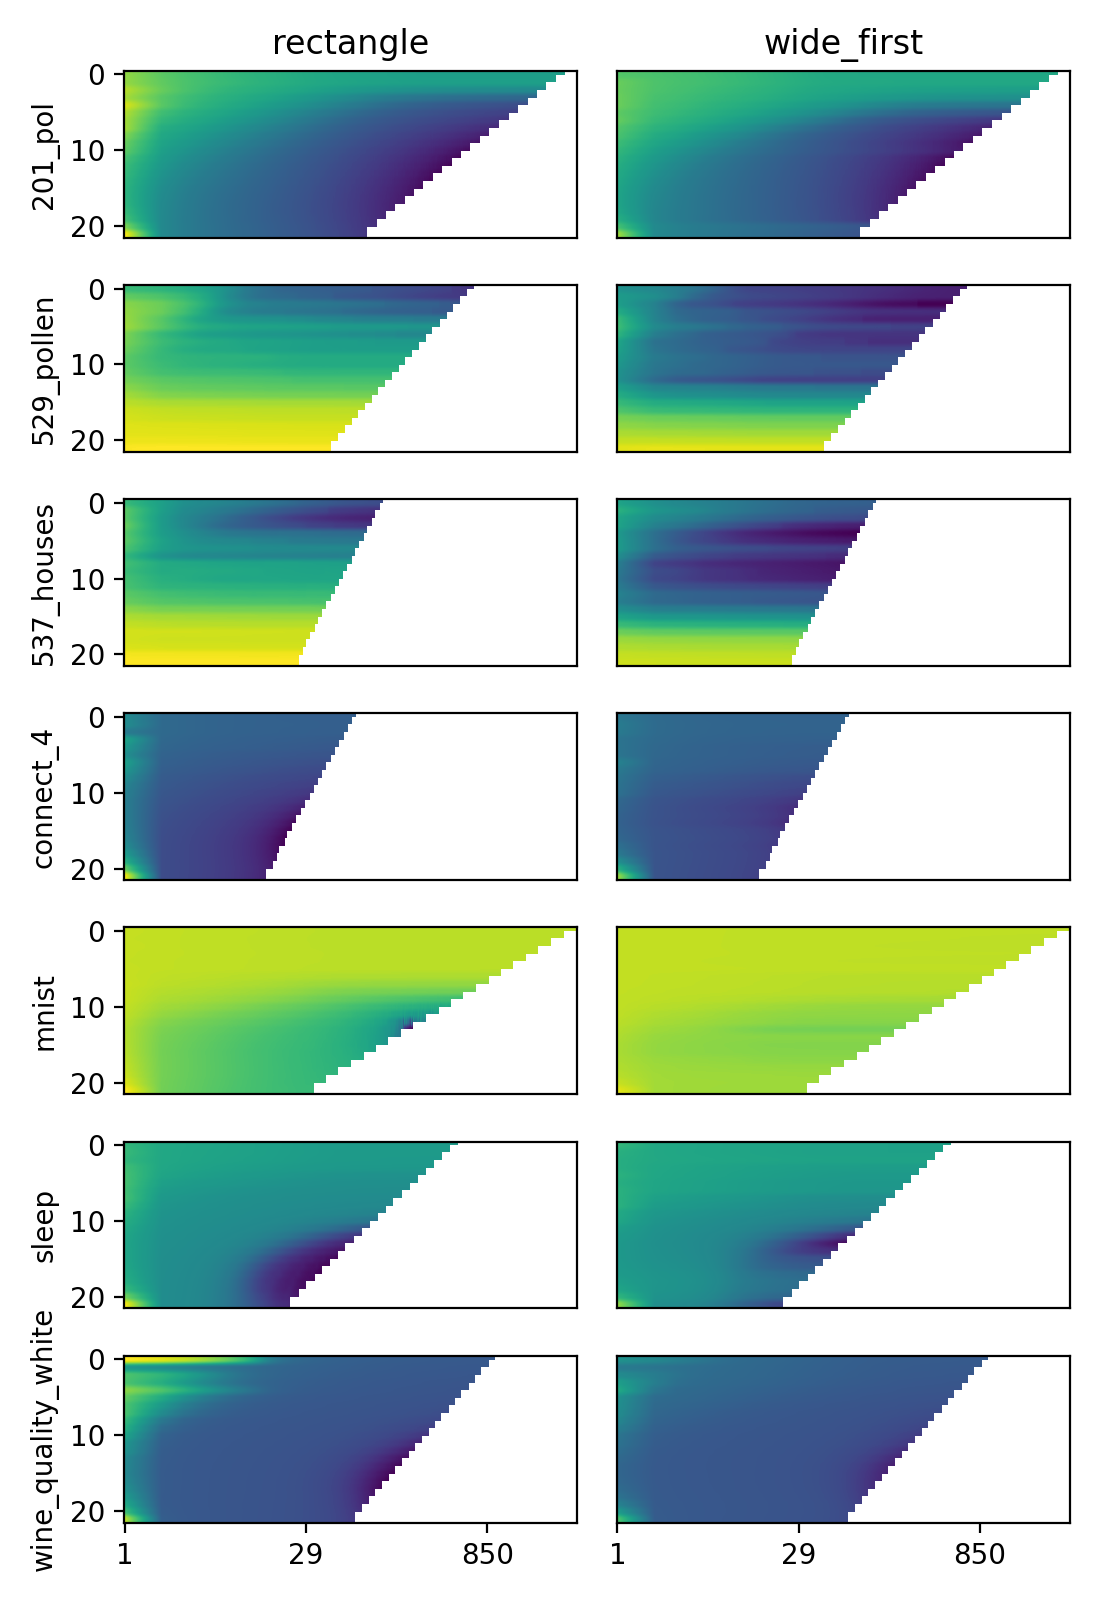

In [36]:
query_string = f'''
select "config.budget", avg(a.val) as value, count(a.val), a.epoch, "config.dataset", "config.topology"
from
    materialized_experiments_0 t,
    unnest(t.history_loss) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname"='fixed_01' and
    "config.residual_mode"='full'
GROUP BY epoch, "config.budget", "config.dataset", "config.topology"
'''
df = cached_query(query_string)
df["effort"] = np.log((df["epoch"]))
#df["effort"] = np.log2((df["config.budget"]*(df["epoch"]))) - np.log2(df["config.budget"])
#df["effort"] = np.log(df["config.budget"]*df["epoch"])
#df["effort"] = np.log1p(df["config.budget"]*(df["epoch"]-1))


df["value"] = np.log(df["value"])

x_axes = np.linspace(df["effort"].min(), df["effort"].max(), 500)

ROWS = 7
COLS = 2

fig, axs = plt.subplots(ROWS,COLS, figsize=(5.5,8), dpi=100, sharex=True)

i = 0
for idx, gdf in df.groupby(["config.dataset", "config.topology"]):
    img = np.ndarray(shape=(22,500))

    for row_idx, row_df in gdf.groupby("config.budget"):
        intp = scipy.interpolate.interp1d(row_df["effort"],
                                          row_df["value"],
                                          kind='linear',
                                          bounds_error=False)

        row_idx = int(np.log2(row_idx)-5)
        img[row_idx, :] = intp(x_axes)

        
    value_min = df[df["config.dataset"]==idx[0]]["value"].min()
    value_max = df[df["config.dataset"]==idx[0]]["value"].max()
    
    ax = axs[i//COLS, i%COLS]
    ax.imshow(img, aspect="auto", vmin=value_min, vmax=value_max)

    if i%COLS == 0:
        ax.set_ylabel(idx[0])
    else:
        ax.yaxis.set_visible(False)

    if i//COLS != 6:
        ax.xaxis.set_visible(False)

    if i//COLS == 0:
        ax.set_title(idx[1])
        
    if i//COLS == 6:
        ax.set_xticks(list(range(0,500,200)), minor=False)
        labels = [f"{int(np.exp(x))}" for x in x_axes[::200]]
        ax.set_xticklabels(labels, fontdict=None, minor=False)

    i = i + 1
    
plt.tight_layout()

